<a href="https://colab.research.google.com/github/TrSaleMane/deep-learning-from-step-by-step/blob/main/vol07_nn_from_scratch_2/vol07_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vol.7：ニューラルネットを“ゼロから”実装する（後編）

このノートブックでは、前編で作ったニューラルネットに対して

- 損失の計算  
- 勾配の計算（Backpropagation）  
- パラメータ更新（SGD）  
- 1エポック学習  

をゼロから実装します。

####準備（ライブラリ & データ読み込み）

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# データ読み込み
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

print("\n")
print("学習データ数：", len(train_dataset))

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 340kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.22MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.35MB/s]



学習データ数： 60000


###手書きニューラルネットクラス（forward 含む）に下記の関数を追加します。

 - Softmax と CrossEntropy の実装

```
def softmax(x):
    # x: [batch, num_classes]
    x_exp = torch.exp(x - x.max(dim=1, keepdim=True).values)
    return x_exp / x_exp.sum(dim=1, keepdim=True)

def cross_entropy(pred, target):
    # pred: [batch, num_classes]（確率）
    # target: [batch]（正解ラベル）
    batch_size = pred.shape[0]
    log_likelihood = -torch.log(pred[range(batch_size), target])
    return log_likelihood.mean()
```

 - 出力層の勾配（Softmax + CrossEntropy）

```
def grad_output_layer(pred, target):
    # pred: [batch, num_classes]
    # target: [batch]
    batch_size = pred.shape[0]
    grad = pred.clone()
    grad[range(batch_size), target] -= 1
    grad /= batch_size
    return grad
```

###クラスに backward と update を追加

前回のSimpleNNをもとに、SimpleNNTrainerとして再作成します。

backward関数 と update関数 を追加します。

In [2]:
import torch

class SimpleNNTrainer:
    """
    手書きニューラルネット
    - forward（順伝播）
    - backward（勾配計算）
    - update（パラメータ更新）
    をすべて自前で実装したクラス
    """

    def __init__(self, input_dim=784, hidden_dim=128, output_dim=10):
        # --- パラメータの初期化 ---
        # 1層目：入力784 → 隠れ層128
        self.W1 = torch.randn(input_dim, hidden_dim) * 0.01
        self.b1 = torch.zeros(hidden_dim)

        # 2層目：隠れ層128 → 出力10
        self.W2 = torch.randn(hidden_dim, output_dim) * 0.01
        self.b2 = torch.zeros(output_dim)

    # --- 基本演算 ---
    def linear(self, x, W, b):
        return x @ W + b

    def relu(self, x):
        return torch.maximum(x, torch.tensor(0.0))

    def predict(self, x):
        logits = self.forward(x)
        preds = torch.argmax(logits, dim=1)
        return preds

    # --- Softmax（確率に変換） ---
    def softmax(self, x):
        x_exp = torch.exp(x - x.max(dim=1, keepdim=True).values)
        return x_exp / x_exp.sum(dim=1, keepdim=True)

    # --- Cross Entropy（損失） ---
    def cross_entropy(self, pred, target):
        batch_size = pred.shape[0]
        log_likelihood = -torch.log(pred[range(batch_size), target])
        return log_likelihood.mean()

    # --- forward（順伝播） ---
    def forward(self, x):
        """
        x: [batch, 784]
        """
        self.x = x  # backwardで使うので保存

        # 1層目
        self.h = self.linear(x, self.W1, self.b1)
        self.h_relu = self.relu(self.h)

        # 2層目（出力）
        self.out = self.linear(self.h_relu, self.W2, self.b2)

        return self.out  # logits（確率ではない）

    # --- backward（勾配計算） ---
    def backward(self, pred, target):
        """
        pred: softmax後の確率 [batch, 10]
        target: 正解ラベル [batch]
        """

        batch_size = pred.shape[0]

        # 出力層の勾配（Softmax + CrossEntropy の性質）
        grad_out = pred.clone()
        grad_out[range(batch_size), target] -= 1
        grad_out /= batch_size

        # --- 出力層の勾配 ---
        self.dW2 = self.h_relu.T @ grad_out
        self.db2 = grad_out.sum(dim=0)

        # --- 隠れ層の勾配 ---
        dh = grad_out @ self.W2.T
        dh[self.h <= 0] = 0  # ReLU の勾配

        self.dW1 = self.x.T @ dh
        self.db1 = dh.sum(dim=0)

    # --- パラメータ更新（SGD） ---
    def update(self, lr=0.1):
        self.W1 -= lr * self.dW1
        self.b1 -= lr * self.db1
        self.W2 -= lr * self.dW2
        self.b2 -= lr * self.db2

####1バッチだけ学習してみる
1バッチだとlossはおよそ2.3あたり

In [3]:
model = SimpleNNTrainer()

images, labels = next(iter(train_loader))
x = images.view(images.size(0), -1)   # [batch, 784]

# forward
logits = model.forward(x)
pred = model.softmax(logits)

# loss
loss = model.cross_entropy(pred, labels)
print("loss:", loss.item())

# backward
model.backward(pred, labels)

# update
model.update(lr=0.1)

loss: 2.301666736602783


####1エポック学習と loss の推移
lossの数値がだんだん小さくなっていくと、精度があがっているということ

In [4]:
model = SimpleNNTrainer()
lr = 0.1
loss_list = []

for epoch in range(3):
    for batch_idx, (x, y) in enumerate(train_loader): #1回だけ初期化して、そのまま全バッチを通して学習が進むようにする。
        x = x.view(x.size(0), -1)

        logits = model.forward(x)
        pred = model.softmax(logits)
        loss = model.cross_entropy(pred, y)
        loss_list.append(loss.item())

        model.backward(pred, y)
        model.update(lr)

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 0.0973
Epoch 2, Loss: 0.1372
Epoch 3, Loss: 0.2629


####loss のグラフを描画

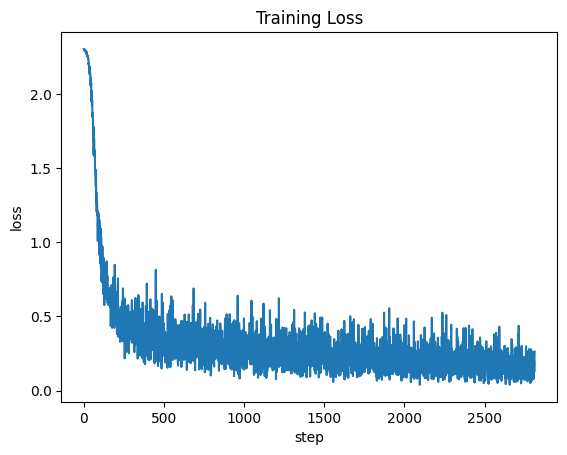

In [5]:
plt.plot(loss_list)
plt.title("Training Loss")
plt.xlabel("step")
plt.ylabel("loss")
plt.show()

学習済みのニューラルネットワーク（SimpleNNTrainer）で、推論（predict）の実行

In [6]:
# images を x に再度設定
x = images.view(images.size(0), -1)   # [batch, 784]

# predict関数の呼び出し
y = model.predict(x)
print("予測ラベル:", y[:10])

予測ラベル: tensor([7, 6, 7, 2, 3, 3, 8, 4, 3, 0])


このクラス（SimpleNNTrainer）で実装したニューラルネットワークについても読み込んだMNISTの画像を表示してみます。

前回に比べて、T（正解ラベル）の数字とP（予測ラベル）の数字が一致している確率があがっていれば、手書き数字認識の精度が上がっています。

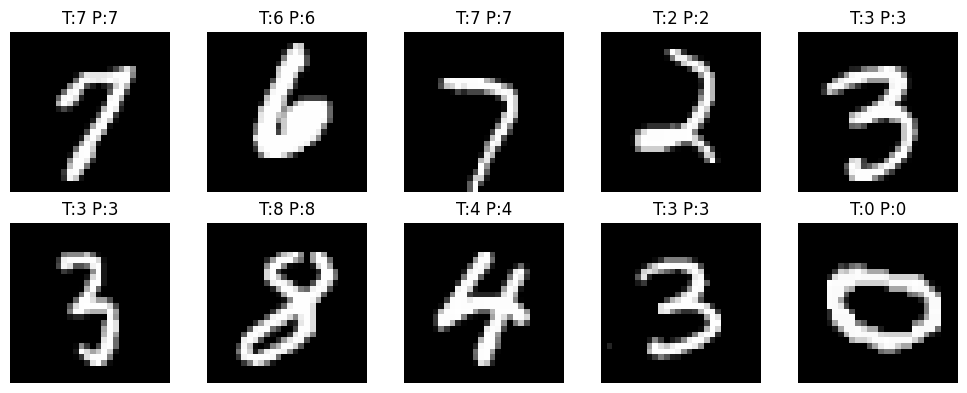

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

for i in range(10):
    plt.subplot(2, 5, i+1)
    img = images[i].squeeze()
    plt.imshow(img, cmap='gray')
    plt.title(f"T:{labels[i].item()} P:{y[i].item()}")
    plt.axis('off')

plt.tight_layout()
plt.show()

##SimpleNNTrainerクラスの内容について

####🧠 1. __init__：重みとバイアスの初期化
ニューラルネットの本体は 重み（W）とバイアス（b）。
- W1: 784 → 128
- W2: 128 → 10

という構造。

```
self.W1 = torch.randn(784, 128) * 0.01
self.b1 = torch.zeros(128)
```

####🧮 2. forward()：順伝播の流れ

ニューラルネットの計算は
入力 → 線形変換 → ReLU → 線形変換 → 出力
という流れになっています。

```
self.h = self.linear(x, self.W1, self.b1)
self.h_relu = self.relu(self.h)
self.out = self.linear(self.h_relu, self.W2, self.b2)
```
ここで返すのは logits（確率ではない生のスコアです）

####🔥 3. softmax()：確率に変換

Softmax は
- 大きい値 → 大きい確率
- 小さい値 → 小さい確率
に変換する関数。

```
x_exp = torch.exp(x - x.max(dim=1, keepdim=True).values)
```
x - x.max() をする理由：
- 数値が爆発しないようにするため
- 安定した計算のための定石のようなものです

####📉 4. cross_entropy()：損失の計算

正解ラベルの確率だけを取り出して

「どれくらい間違えているか？」を数値化します。

```
log_likelihood = -torch.log(pred[range(batch_size), target])
```

####🔁 5. backward()：勾配計算（学習のポイント）

Softmax + CrossEntropy の組み合わせは

勾配が p - y になるという仕様。

```
grad_out = pred.clone()
grad_out[range(batch_size), target] -= 1
grad_out /= batch_size
```

これが出力層の勾配。

隠れ層の勾配

```
dh = grad_out @ self.W2.T
dh[self.h <= 0] = 0  # ReLU の勾配
```

ReLU の勾配は
- 正の部分 → 1
- 負の部分 → 0
というシンプルなルールです。

####🔧 6. update()：パラメータ更新（SGD）

```
self.W1 -= lr * self.dW1
```
これが 学習の本質であるパラメータの更新。

- 損失が減る方向に少しずつ重みを動かすのがポイント

これを何千回も繰り返すと「数字を判別できるようになります」。


##1エポック学習と loss の推移の内容について

✨ 1. モデルの初期化（最初の1回だけ）

```
model = SimpleNNTrainer()
lr = 0.1
loss_list = []
```

- SimpleNNTrainer() でニューラルネットの重みを初期化する
- lr = 0.1 は学習率
- loss_list は学習の進み具合を記録するためのリスト

👉 ここが重要：モデルは1回しか初期化しません。
これにより、重みがエポックをまたいで蓄積され、学習が進みます。

✨ 2. エポックのループ（3回繰り返す）
```
for epoch in range(3):
```
- データセットを3周する
- 1周＝1エポック

✨ 3. バッチごとの学習処理

```
for batch_idx, (x, y) in enumerate(train_loader):
```
- train_loader からミニバッチを取り出す
- x は画像、y は正解ラベル
- batch_idx はバッチ番号（進捗表示などに使える）

✨ 4. 入力画像を flatten（784次元に変換）

```
x = x.view(x.size(0), -1)
```
- MNIST画像（28×28）を 784 次元のベクトルに変換
- 全結合層に入力できる形にするため

✨ 5. forward（順伝播）

```
logits = model.forward(x)
pred = model.softmax(logits)
```
- forward でネットワークの出力（logits）を計算
- softmax で確率に変換
- pred は「各クラスの確率」

✨ 6. 損失を計算

```
loss = model.cross_entropy(pred, y)
loss_list.append(loss.item())
```
- 予測 pred と正解 y のズレを計算
- loss_list に記録しておく（後で学習曲線を描ける）

✨ 7. backward（逆伝播）

```
model.backward(pred, y)
```
- 損失をもとに勾配を計算
- 各パラメータに「どれだけ更新すべきか」が求まる

✨ 8. update（パラメータ更新）

```
model.update(lr)
```
- 学習率 lr に従って重みを更新
- これが「学習」の本体

✨ 9. エポック終了時のログ

```
print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
```
- そのエポックの最後のバッチの loss を表示
- 学習が進むにつれて loss が下がっていくはず


## ▶ 次のステップ

ここまでで、

- 損失の計算（Softmax + CrossEntropy）  
- 勾配の計算（Backpropagation）  
- パラメータ更新（SGD）  
- 1エポック学習と loss の推移  

をすべて “手書き” で体験しました。

Vol.8 では、いよいよ **PyTorch の `nn.Module` を使って  
MNIST モデルを実装** していきます。